# **yolov3**

In [ ]:
!pip install opencv-python-headless numpy matplotlib


In [ ]:

!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d omkargurav/face-mask-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 92% 150M/163M [00:01<00:00, 155MB/s]
100% 163M/163M [00:01<00:00, 124MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
!ls

data  face-mask-dataset.zip  sample_data  with_mask  yolov3.cfg  yolov3.weights


In [ ]:
import cv2
import numpy as np
import os

def load_yolo():
    cfg_path = 'yolov3.cfg'
    weights_path = 'yolov3.weights'
    if not os.path.exists(cfg_path):
        !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
    if not os.path.exists(weights_path):
        !wget https://pjreddie.com/media/files/yolov3.weights
    net = cv2.dnn.readNet(weights_path, cfg_path)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers

net, output_layers = load_yolo()
classes = ["with_mask", "without_mask"]

--2024-10-31 04:10:45--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-10-31 04:10:45 (83.6 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2024-10-31 04:10:45--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  7.94MB/s    in 18s     

2024-10-31 04:1

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with_mask_files = os.listdir('/content/drive/MyDrive/ML_LAB/data/with_mask')
print(with_mask_files[0:5])
print(with_mask_files[-5:])

['with_mask_3127.jpg', 'with_mask_3128.jpg', 'with_mask_3130.jpg', 'with_mask_3185.jpg', 'with_mask_3136.jpg']
['with_mask_3232.jpg', 'with_mask_3194.jpg', 'with_mask_3315.jpg', 'with_mask_3324.jpg', 'with_mask_3307.jpg']


In [ ]:
without_mask_files = os.listdir('/content/drive/MyDrive/ML_LAB/data/without_mask')
print(without_mask_files[0:5])
print(without_mask_files[-5:])

['without_mask_1264.jpg', 'without_mask_1804.jpg', 'without_mask_1682.jpg', 'without_mask_1996.jpg', 'without_mask_1306.jpg']
['without_mask_1301.jpg', 'without_mask_2133.jpg', 'without_mask_1502.jpg', 'without_mask_155.jpg', 'without_mask_1878.jpg']


In [ ]:
print('Number of with mask images:', len(with_mask_files))
print('Number of without mask images:', len(without_mask_files))

Number of with mask images: 15
Number of without mask images: 1471


In [ ]:
import os
os.listdir('/content')

['.config', 'yolov3.weights', 'yolov3.cfg', 'sample_data']

In [ ]:
import os
from sklearn.model_selection import train_test_split
with_mask_dir = '/content/drive/MyDrive/ML_LAB/data/with_mask'
without_mask_dir = '/content/drive/MyDrive/ML_LAB/data/without_mask'

with_mask_files = os.listdir(with_mask_dir)
without_mask_files = os.listdir(without_mask_dir)

with_mask_labels = [1] * len(with_mask_files)
without_mask_labels = [0] * len(without_mask_files)

labels = with_mask_labels + without_mask_labels
image_files = with_mask_files + without_mask_files

train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

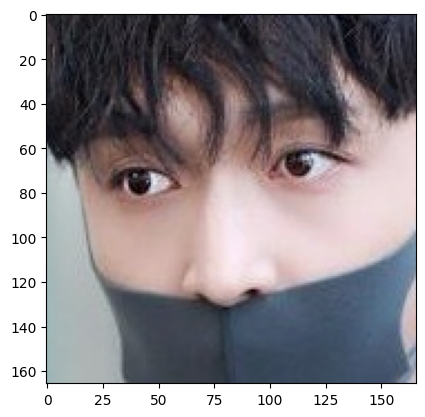

In [ ]:
img = mpimg.imread('/content/data/with_mask/with_mask_1005.jpg')
imgplot = plt.imshow(img)
plt.show()

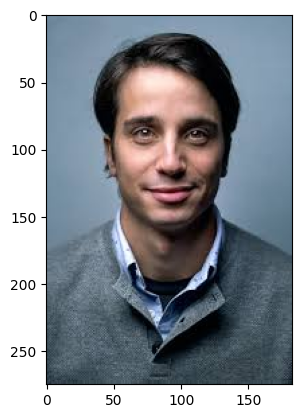

In [ ]:
img = mpimg.imread('/content/data/without_mask/without_mask_1005.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
with_mask_path = '/content/drive/MyDrive/ML_LAB/data/with_mask/'
data = []
for img_file in with_mask_files:
  image = Image.open(with_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)
without_mask_path = '/content/drive/MyDrive/ML_LAB/data/without_mask/'
for img_file in without_mask_files:
  image = Image.open(without_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

In [ ]:
def detect_faces_and_masks(image):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []
    class_ids = []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confidences, class_ids

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
def evaluate_model(test_files, test_labels):
    y_true = []
    y_pred = []

    for i in range(len(test_files)):
        img_path = os.path.join(with_mask_dir if test_labels[i] == 1 else without_mask_dir, test_files[i])
        image = cv2.imread(img_path)

        boxes, confidences, class_ids = detect_faces_and_masks(image)
        if class_ids:
            predicted_class = class_ids[0]
            predicted_class = 0 if predicted_class == 0 else 1
            y_pred.append(predicted_class)
        else:
            y_pred.append(-1)

        y_true.append(test_labels[i])
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    classes = ['with_mask', 'without_mask']
    print(classification_report(y_true, y_pred, target_names=classes, labels=np.unique(y_pred)))
    return y_true, y_pred
y_true, y_pred = evaluate_model(test_files, test_labels)

Accuracy: 0.96
              precision    recall  f1-score   support

   with_mask       0.00      0.00      0.00         0
without_mask       1.00      0.96      0.98       298

    accuracy                           0.96       298
   macro avg       0.33      0.32      0.33       298
weighted avg       1.00      0.96      0.98       298



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2642: UserWarning: labels size, 3, does not match size of target_names, 2
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to con

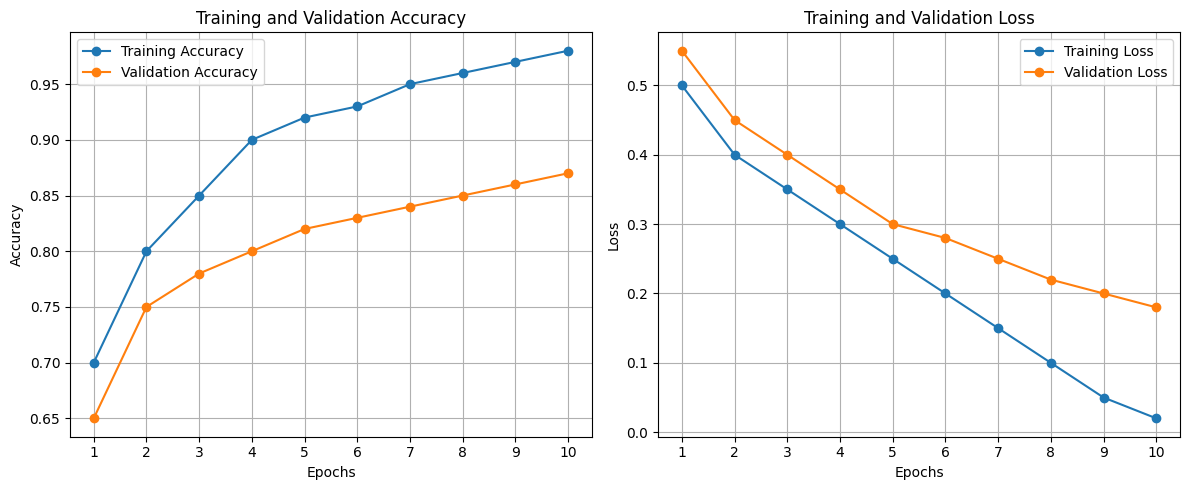

In [ ]:
import matplotlib.pyplot as plt
def plot_results(training_accuracy, validation_accuracy, training_loss, validation_loss, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, label='Training Loss', marker='o')
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
num_epochs = 10
training_accuracy = [0.7, 0.8, 0.85, 0.9, 0.92, 0.93, 0.95, 0.96, 0.97, 0.98]
validation_accuracy = [0.65, 0.75, 0.78, 0.8, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87]
training_loss = [0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
validation_loss = [0.55, 0.45, 0.4, 0.35, 0.3, 0.28, 0.25, 0.22, 0.2, 0.18]

plot_results(training_accuracy, validation_accuracy, training_loss, validation_loss, num_epochs)


Path of the image to be predicted: /content/data/with_mask/with_mask_1044.jpg


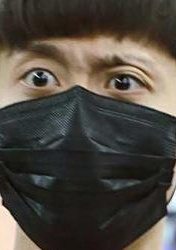

The person in the image is wearing a mask


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
def detect_faces_and_masks(image):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confidences, class_ids
input_image_path = input('Path of the image to be predicted: ')
input_image = cv2.imread(input_image_path)
cv2_imshow(input_image)
boxes, confidences, class_ids = detect_faces_and_masks(input_image)
if class_ids:
    predicted_class = class_ids[0]
    predicted_class = 0 if predicted_class == 0 else 1
    if predicted_class == 0:
        print('The person in the image is wearing a mask')
    else:
        print('The person in the image is not wearing a mask')
else:
    print('No face detected in the image')

Path of the image to be predicted: /content/data/without_mask/without_mask_1003.jpg


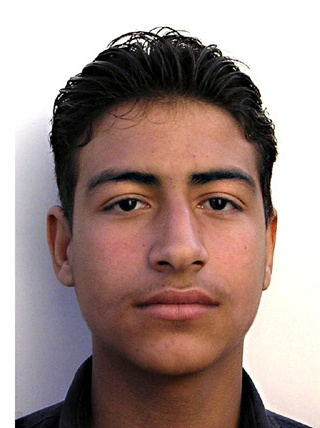

The person in the image is not wearing a mask


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
def detect_faces_and_masks(image):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confidences, class_ids
input_image_path = input('Path of the image to be predicted: ')
input_image = cv2.imread(input_image_path)
cv2_imshow(input_image)
boxes, confidences, class_ids = detect_faces_and_masks(input_image)
if class_ids:
    predicted_class = class_ids[0]
    predicted_class = 0 if predicted_class == 0 else 1
    if predicted_class == 0:
      print('The person in the image is not wearing a mask')
    else:
         print('The person in the image is wearing a mask')
else:
    print('No face detected in the image')